# Course - CS-513 Knowledge Discovery and Data Mining

#### Problem Statement - User friendly guide to predict if a house in NYC would fall in a specific price range(L, M, H, VH)

#### Project Group 6

#### Team Members:
- Akhil Vandanapu (20016200)
- Anirudh Chintha (20016080)
- Pooja Mule (20016077)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [2]:
# Load dataset
df = pd.read_csv('nyc-rolling-sales.csv')

# Check dataset columns pre-cleanup
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

## Data Analysis and Preprocessing

In [3]:
# Clean dataset

print("Removing unwanted columns and replacing weird empty values with NaN")
print("\n")

# Drop Unnamed: 0 feature which is just a serial number
# Drop ADDRESS and LOT features as it is not required for analysis(We are going to use zip code instead)
df.drop(["ADDRESS", "Unnamed: 0", "LOT", "SALE DATE"], axis=1, inplace=True)

# Check and drop columns where all cells are empty or -
df = df.applymap(lambda x: pd.NA if str(x).strip() in ["-", ""] else x)
df.dropna(axis=1, how="all", inplace=True)

print("Dataset columns post-cleanup")
df.info()

Removing unwanted columns and replacing weird empty values with NaN


Dataset columns post-cleanup
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            83810 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   BUILDING CLASS AT PRESENT       83810 non-null  object
 6   APARTMENT NUMBER                19052 non-null  object
 7   ZIP CODE                        84548 non-null  int64 
 8   RESIDENTIAL UNITS               84548 non-null  int64 
 9   COMMERCIAL UNITS                84548 non-null  int64 
 10  TOTAL UNITS                     84548 non-null  int64 
 11  LAND SQ

In [4]:
# View dataset shape and head

print('(Rows, Columns):', df.shape)
df.head()

(Rows, Columns): (84548, 17)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,BUILDING CLASS AT PRESENT,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,C2,<NA>,10009,5,0,5,1633,6440,1900,2,C2,6625000
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,C7,<NA>,10009,28,3,31,4616,18690,1900,2,C7,<NA>
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,C7,<NA>,10009,16,1,17,2212,7803,1900,2,C7,<NA>
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,C4,<NA>,10009,10,0,10,2272,6794,1913,2,C4,3936272
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,C2,<NA>,10009,6,0,6,2369,4615,1900,2,C2,8000000


In [5]:
# Remove rows where commercial units and residential units do not add up to total uints
print(
    "Rows with total units != commercial units + residential units:",
    df[df["TOTAL UNITS"] != df["COMMERCIAL UNITS"] + df["RESIDENTIAL UNITS"]].shape[0],
)

df = df[df["TOTAL UNITS"] == (df["COMMERCIAL UNITS"] + df["RESIDENTIAL UNITS"])]

print(
    "Rows with total units != commercial units + residential units after removing:",
    df[df["TOTAL UNITS"] != df["COMMERCIAL UNITS"] + df["RESIDENTIAL UNITS"]].shape[0],
)

print("\n")

print("Data type of features", df.dtypes)

Rows with total units != commercial units + residential units: 2650
Rows with total units != commercial units + residential units after removing: 0


Data type of features BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
BUILDING CLASS AT PRESENT         object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
dtype: object


In [6]:
# Find categorical columns - columns with less than 10 unique values considered cateogrical for our purpose

categorical_columns = []

for column in df.columns:
    if df[column].dtype == 'object' or df[column].nunique() < 10:
        categorical_columns.append(column)


print('Categorical columns:')
print(categorical_columns, '\n')

Categorical columns:
['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE'] 



In [7]:
# Filter out categorical features from 'categorical_columns' if they are truly useful in categorical sense
categorical_columns = [
    'BOROUGH',
    'NEIGHBORHOOD',
    'TAX CLASS AT PRESENT',
    'BUILDING CLASS CATEGORY',
    'BUILDING CLASS AT PRESENT',
    'TAX CLASS AT TIME OF SALE',
    'BUILDING CLASS AT TIME OF SALE',
]

for col in categorical_columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

# Convert other feature data types to numeric wherever suitable
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'])
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

In [8]:
# Check if all features are appropriately set as per thier data types
print("Data type of features:")
df.dtypes

Data type of features:


BOROUGH                              int8
NEIGHBORHOOD                        int16
BUILDING CLASS CATEGORY              int8
TAX CLASS AT PRESENT                 int8
BLOCK                               int64
BUILDING CLASS AT PRESENT           int16
APARTMENT NUMBER                   object
ZIP CODE                            int64
RESIDENTIAL UNITS                   int64
COMMERCIAL UNITS                    int64
TOTAL UNITS                         int64
LAND SQUARE FEET                  float64
GROSS SQUARE FEET                 float64
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE            int8
BUILDING CLASS AT TIME OF SALE      int16
SALE PRICE                        float64
dtype: object

In [9]:
# We tried to remove extreme values from SALE PRICE but it resulted in loss of data. So we decided to keep them.

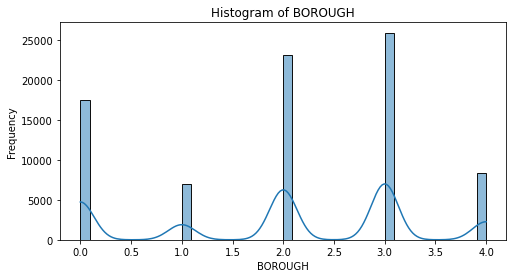

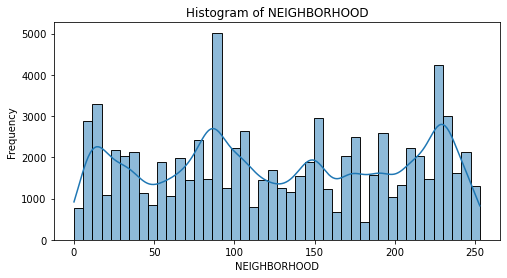

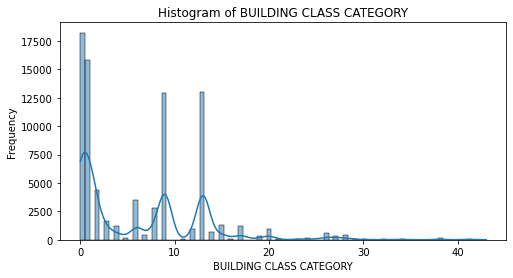

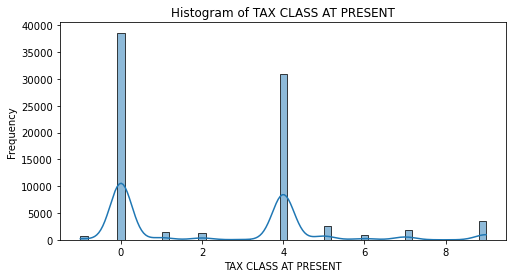

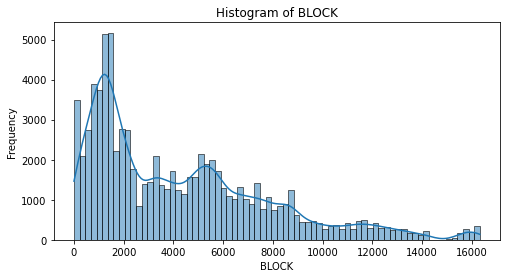

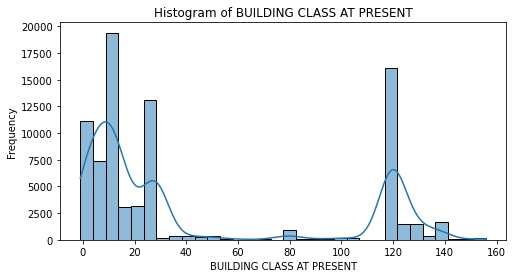

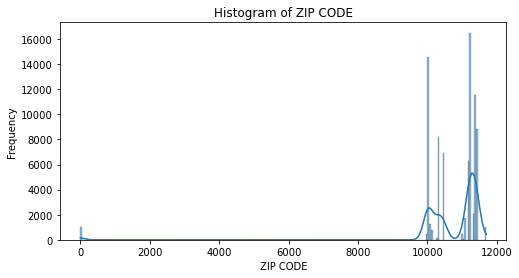

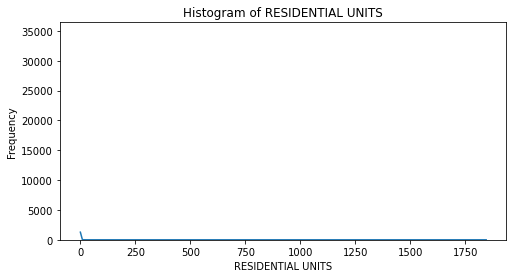

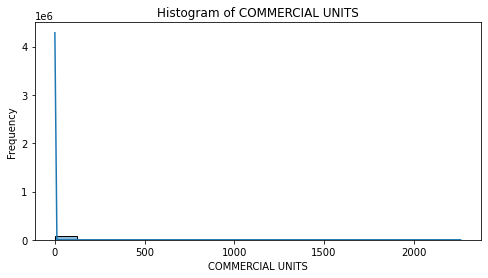

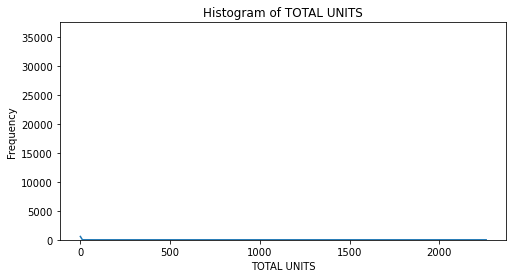

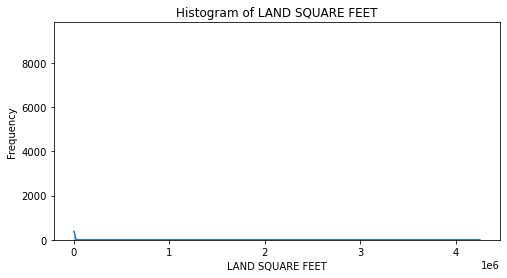

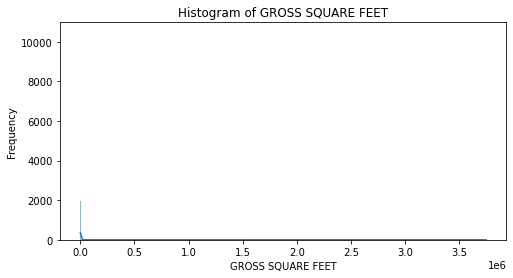

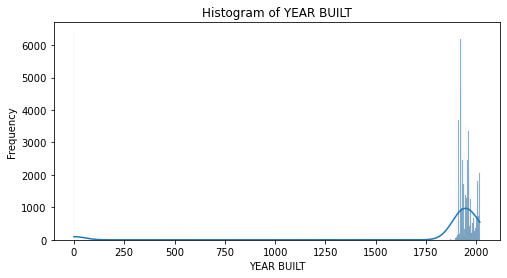

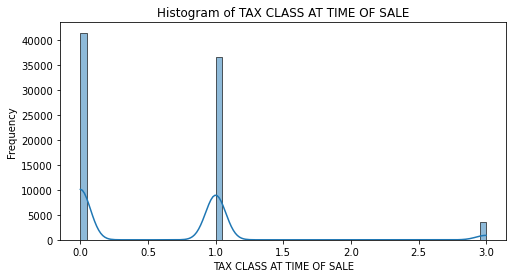

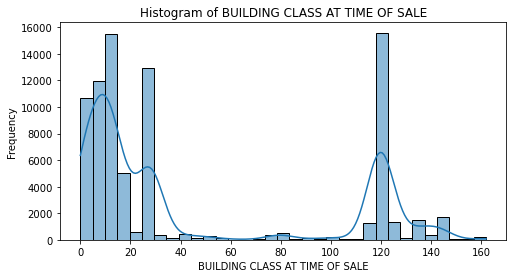

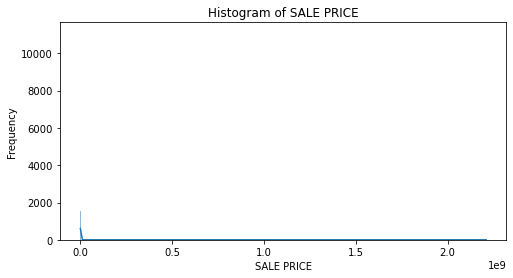

In [10]:
# Plot histogram for numerical data
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

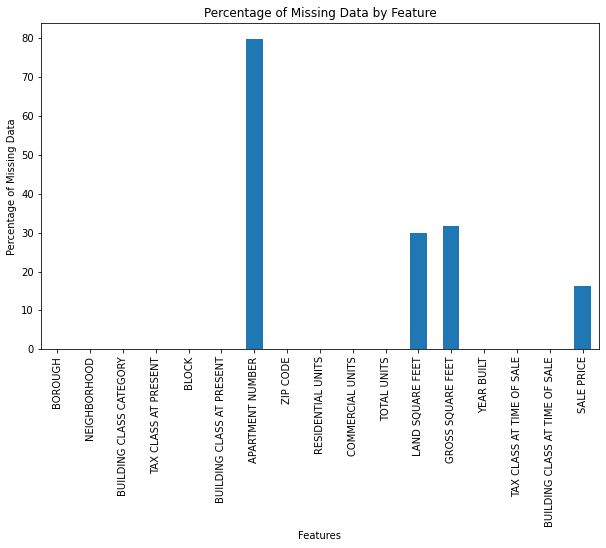

In [11]:
# Missing data - understand percentage of missing data

# Calculate missing % and create a barchart.
def show_missing_values(dataframe):
    missing_percentage = dataframe.isnull().mean() * 100

    plt.figure(figsize=(10, 6))
    missing_percentage.plot(kind="bar")
    plt.ylabel("Percentage of Missing Data")
    plt.xlabel("Features")
    plt.title("Percentage of Missing Data by Feature")
    plt.show()

show_missing_values(df)

## Handle Missing Values

In [12]:
# Treating missing values

# Cateogorical values for SALE PRICE
SALE_PRICE_LABELS = ["Low", "Medium", "High", "Very High"]

# Replace YEAR BUILT = 0 with mode value
df["YEAR BUILT"] = df["YEAR BUILT"].replace(0, df["YEAR BUILT"].mode()[0])

# Remove rows with missing or 0 values in SALE PRICE which is target variable
df["SALE PRICE"] = df["SALE PRICE"].apply(lambda x: np.NAN if x <= 0 or "" else x)
df.dropna(subset=["SALE PRICE"], inplace=True)

# Verify if SALE PRICE has any NA values
print(
    "Number of null or 0 values after cleanup from SALE PRICE:",
    df["SALE PRICE"].isna().sum(),
)

# KNN imputation for 0 values of zip code
imputer = KNNImputer(n_neighbors=5)
df["ZIP CODE"] = imputer.fit_transform(df[["ZIP CODE"]])


# Delete the APARTMENT NUMBER since 77% of the values are missing.
df.drop("APARTMENT NUMBER", axis=1, inplace=True)


# Remove rows with missing values in TAX CLASS AT PRESENT and BUILDING CLASS AT PRESENT
df.dropna(subset=["TAX CLASS AT PRESENT", "BUILDING CLASS AT PRESENT"], inplace=True)

# Convert SALE PRICE to categorical variable
df["SALE PRICE"] = pd.qcut(df["SALE PRICE"], q=4, labels=SALE_PRICE_LABELS)

df.info()

Number of null or 0 values after cleanup from SALE PRICE: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 58960 entries, 0 to 84547
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         58960 non-null  int8    
 1   NEIGHBORHOOD                    58960 non-null  int16   
 2   BUILDING CLASS CATEGORY         58960 non-null  int8    
 3   TAX CLASS AT PRESENT            58960 non-null  int8    
 4   BLOCK                           58960 non-null  int64   
 5   BUILDING CLASS AT PRESENT       58960 non-null  int16   
 6   ZIP CODE                        58960 non-null  float64 
 7   RESIDENTIAL UNITS               58960 non-null  int64   
 8   COMMERCIAL UNITS                58960 non-null  int64   
 9   TOTAL UNITS                     58960 non-null  int64   
 10  LAND SQUARE FEET                38270 non-null  float64 
 11  GROSS SQUARE FEET   

In [13]:
print("Initial DF Shape: ", df.shape)
# Create duplicate df for imputation
df_median_impute = df.copy(deep=True)
df_mean_inpute = df.copy(deep=True)
df_knn_impute = df.copy(deep=True)
df_no_impute = df.copy(deep=True)

# Impute the missing values in LAND SQUARE FEET and GROSS SQUARE FEET using different methods

# Impute using median
df_median_impute['LAND SQUARE FEET'] = df_median_impute['LAND SQUARE FEET'].fillna(df_median_impute['LAND SQUARE FEET'].median())
df_median_impute['GROSS SQUARE FEET'] = df_median_impute['GROSS SQUARE FEET'].fillna(df_median_impute['GROSS SQUARE FEET'].median())
# # do log1p transformation to make the data more normally distributed
# df_median_impute['LAND SQUARE FEET'] = np.log1p(df_median_impute['LAND SQUARE FEET'])
# df_median_impute['GROSS SQUARE FEET'] = np.log1p(df_median_impute['GROSS SQUARE FEET'])
print("DF Median Impute Shape: ", df_median_impute.shape)

# Impute using mean
df_mean_inpute['LAND SQUARE FEET'] = df_mean_inpute['LAND SQUARE FEET'].fillna(df_mean_inpute['LAND SQUARE FEET'].mean())
df_mean_inpute['GROSS SQUARE FEET'] = df_mean_inpute['GROSS SQUARE FEET'].fillna(df_mean_inpute['GROSS SQUARE FEET'].mean())
# # do log1p transformation to make the data more normally distributed
# df_mean_inpute['LAND SQUARE FEET'] = np.log1p(df_mean_inpute['LAND SQUARE FEET'])
# df_mean_inpute['GROSS SQUARE FEET'] = np.log1p(df_mean_inpute['GROSS SQUARE FEET'])
print("DF Mean Impute Shape: ", df_mean_inpute.shape)

# Impute using KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_knn_impute['LAND SQUARE FEET'] = imputer.fit_transform(df_knn_impute[['LAND SQUARE FEET']])
df_knn_impute['GROSS SQUARE FEET'] = imputer.fit_transform(df_knn_impute[['GROSS SQUARE FEET']])
# # do log1p transformation to make the data more normally distributed
# df_knn_impute['LAND SQUARE FEET'] = np.log1p(df_knn_impute['LAND SQUARE FEET'])
# df_knn_impute['GROSS SQUARE FEET'] = np.log1p(df_knn_impute['GROSS SQUARE FEET'])
print("DF KNN Impute Shape: ", df_knn_impute.shape)

# Delete rows with missing values fir df_no_impute
df_no_impute.dropna(inplace=True)
# # do log1p transformation to make the data more normally distributed
# df_no_impute['LAND SQUARE FEET'] = np.log1p(df_no_impute['LAND SQUARE FEET'])
# df_no_impute['GROSS SQUARE FEET'] = np.log1p(df_no_impute['GROSS SQUARE FEET'])
print("DF No Impute Shape: ", df_no_impute.shape)

Initial DF Shape:  (58960, 16)
DF Median Impute Shape:  (58960, 16)
DF Mean Impute Shape:  (58960, 16)
DF KNN Impute Shape:  (58960, 16)
DF No Impute Shape:  (37715, 16)


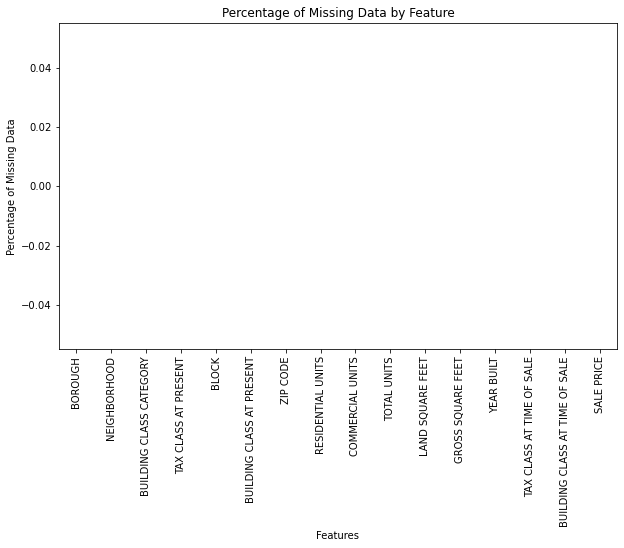

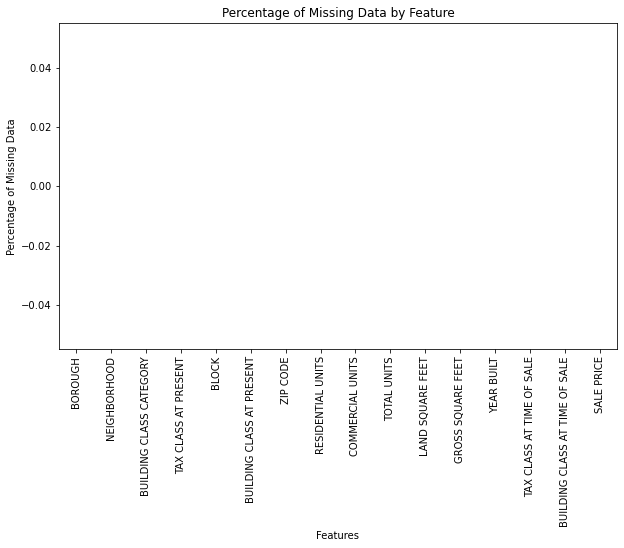

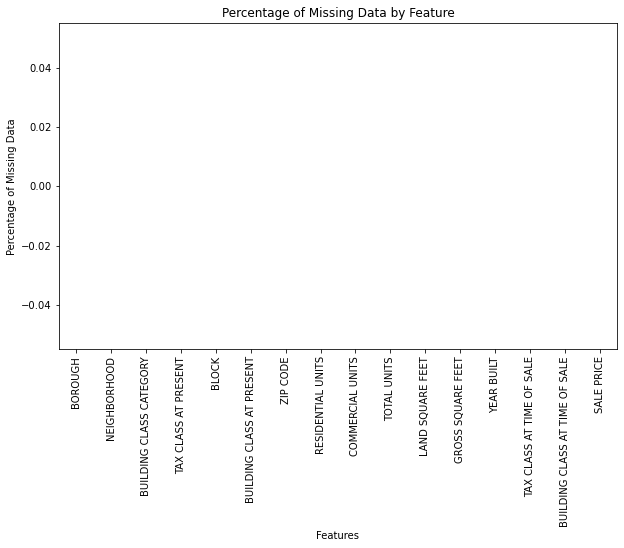

In [14]:
# Showing missing values after cleanup
show_missing_values(df_median_impute)
show_missing_values(df_mean_inpute)
show_missing_values(df_knn_impute)

## Model Predictions

In [15]:
def plot_confusion_matrix(cm, title):
    print(title)
    print(cm)
    print("\n")


def get_predictions(model, attr_train, attr_test, target_train, target_test):
    model.fit(attr_train, target_train)
    return model.predict(attr_test)


# Return optimal k
def get_optimal_k(dataframe):
    attr = dataframe.drop("SALE PRICE", axis=1)
    target = dataframe["SALE PRICE"]

    scaler = MinMaxScaler()
    attr = scaler.fit_transform(attr)

    attr_train, attr_test, target_train, target_test = train_test_split(
        attr, target, test_size=0.3, random_state=42
    )
    k_values = range(1, 21)
    accuracy_map = dict()

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        target_pred = get_predictions(
            knn, attr_train, attr_test, target_train, target_test
        )
        accuracy_map[k] = accuracy_score(target_test, target_pred) * 100

    # Plot the accuracy for different values of k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracy_map.values())
    plt.xticks(k_values)
    plt.xlabel("Value of k")
    plt.ylabel("Testing Accuracy")
    plt.title("Accuracy for different values of k")
    plt.show()

    # Get optimal k
    optimal_k = max(accuracy_map, key=accuracy_map.get)
    return optimal_k


# Return model based on type passed
def get_model(model_type, dataframe):
    if model_type == "gaussian_nb":
        return GaussianNB()
    elif model_type == "decision_tree":
        return DecisionTreeClassifier()
    elif model_type == "cart_5":
        return DecisionTreeClassifier(
            criterion="entropy", max_depth=5, splitter="best", max_leaf_nodes=5
        )
    elif model_type == "random_forest":
        return RandomForestClassifier(n_estimators=100, random_state=7)
    elif model_type == "svm":
        return SVC()
    elif model_type == "knn":
        optimal_k = get_optimal_k(dataframe)
        print("The optimal number of neighbors is {}".format(optimal_k))
        return KNeighborsClassifier(n_neighbors=optimal_k)
    else:
        return None


# Write a common function to train and test the different models
def train_and_test_model(model_type, dataframe):
    # Get the model according to model_type passed
    model = get_model(model_type, dataframe)

    if model is None:
        print("Invalid model type")
        return 0

    attr = dataframe.drop("SALE PRICE", axis=1)
    target = dataframe["SALE PRICE"]

    if model_type == "svm":
        scaler = StandardScaler()
        attr = scaler.fit_transform(attr)
    elif model_type == "knn":
        scaler = MinMaxScaler()
        attr = scaler.fit_transform(attr)

    attr_train, attr_test, target_train, target_test = train_test_split(
        attr, target, test_size=0.3, random_state=42
    )

    target_pred = get_predictions(
        model, attr_train, attr_test, target_train, target_test
    )

    # Get the confusion matrix
    cm = confusion_matrix(target_test, target_pred)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, "Confusion Matrix for " + model_type)

    # Print the classification report
    print(classification_report(target_test, target_pred))

    # Print the accuracy
    accuracy = accuracy_score(target_test, target_pred)
    print("Accuracy:", accuracy)

    return accuracy


def use_xg_boost_model(dataframe):
    label_encoder = LabelEncoder()

    df = dataframe.copy()
    df["SALE PRICE"] = label_encoder.fit_transform(df["SALE PRICE"])

    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=["category"]).columns

    # Use pd.get_dummies() to create dummy variables for categorical columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    attr = df.drop("SALE PRICE", axis=1)
    target = df["SALE PRICE"]

    attr_train, attr_test, target_train, target_test = train_test_split(
        attr, target, test_size=0.3, random_state=42
    )

    # Define the model
    xgb_classifier = xgb.XGBClassifier()
    xgb_classifier.fit(attr_train, target_train)
    y_pred = xgb_classifier.predict(attr_test)

    # Generate and print the confusion matrix
    cm = confusion_matrix(target_test, y_pred)
    plot_confusion_matrix(cm, "Confusion Matrix for XGBClassifier")

    # Print the classification report
    print(classification_report(target_test, y_pred))

    # Print the accuracy
    accuracy = accuracy_score(target_test, y_pred)
    print("Accuracy:", accuracy)

    return accuracy


def use_sequential_dense_modal(dataframe):
    # Get the feature and target columns
    attr = dataframe.drop("SALE PRICE", axis=1)
    target = dataframe["SALE PRICE"]

    # Convert the target column to categorical (one-hot encoding)
    encoded_target = to_categorical(target.cat.codes)

    # Scale the features
    scaler = StandardScaler()
    scaled_attr = scaler.fit_transform(attr)

    attr_train, attr_test, target_train, target_test = train_test_split(
        scaled_attr, encoded_target, test_size=0.3, random_state=42
    )

    n_features = attr_train.shape[1]

    # Build the neural network model
    model = Sequential()
    model.add(Dense(100, activation="softmax", input_shape=(n_features,)))
    model.add(Dense(100, activation="softmax"))
    model.add(Dense(4, activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model.fit(attr_train, target_train, epochs=10, validation_split=0.3)

    loss, accuracy = model.evaluate(attr_test, target_test)
    print(f"Accuracy: {accuracy}")

    return accuracy

Dataframe:  Median Impute


KNN


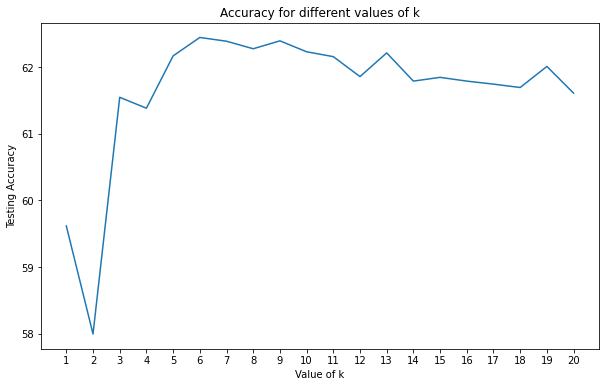

The optimal number of neighbors is 6
Confusion Matrix for knn
[[2727  217  747  749]
 [ 419 3015  746  210]
 [ 978 1020 2213  220]
 [1039  149  148 3091]]


              precision    recall  f1-score   support

        High       0.53      0.61      0.57      4440
         Low       0.69      0.69      0.69      4390
      Medium       0.57      0.50      0.53      4431
   Very High       0.72      0.70      0.71      4427

    accuracy                           0.62     17688
   macro avg       0.63      0.62      0.62     17688
weighted avg       0.63      0.62      0.62     17688

Accuracy: 0.6244911804613297


Gaussian NB
Confusion Matrix for gaussian_nb
[[4379    1   14   46]
 [4245    6   27  112]
 [4380    0    3   48]
 [3948   10  190  279]]


              precision    recall  f1-score   support

        High       0.26      0.99      0.41      4440
         Low       0.35      0.00      0.00      4390
      Medium       0.01      0.00      0.00      4431
   Very High       0

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix for random_forest
[[2609  189  816  826]
 [ 324 2955  906  205]
 [ 787  813 2637  194]
 [ 751   77  135 3464]]


              precision    recall  f1-score   support

        High       0.58      0.59      0.59      4440
         Low       0.73      0.67      0.70      4390
      Medium       0.59      0.60      0.59      4431
   Very High       0.74      0.78      0.76      4427

    accuracy                           0.66     17688
   macro avg       0.66      0.66      0.66     17688
weighted avg       0.66      0.66      0.66     17688

Accuracy: 0.659486657620986


SVM
Confusion Matrix for svm
[[2322  169  711 1238]
 [ 620 2235 1165  370]
 [1234  477 2131  589]
 [1136   63   70 3158]]


              precision    recall  f1-score   support

        High       0.44      0.52      0.48      4440
         Low       0.76      0.51      0.61      4390
      Medium       0.52      0.48      0.50      4431
   Very High       0.59      0.71      0.65      4427

    accur

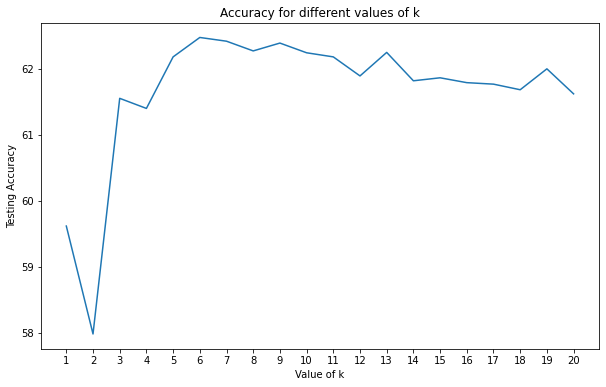

The optimal number of neighbors is 6
Confusion Matrix for knn
[[2729  216  746  749]
 [ 419 3015  746  210]
 [ 976 1020 2215  220]
 [1041  149  146 3091]]


              precision    recall  f1-score   support

        High       0.53      0.61      0.57      4440
         Low       0.69      0.69      0.69      4390
      Medium       0.57      0.50      0.53      4431
   Very High       0.72      0.70      0.71      4427

    accuracy                           0.62     17688
   macro avg       0.63      0.62      0.62     17688
weighted avg       0.63      0.62      0.62     17688

Accuracy: 0.6247173224785165


Gaussian NB
Confusion Matrix for gaussian_nb
[[4379    1   14   46]
 [4245    6   27  112]
 [4381    0    3   47]
 [3951   11  190  275]]


              precision    recall  f1-score   support

        High       0.26      0.99      0.41      4440
         Low       0.33      0.00      0.00      4390
      Medium       0.01      0.00      0.00      4431
   Very High       0

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        High       0.00      0.00      0.00      4440
         Low       0.59      0.51      0.55      4390
      Medium       0.36      0.63      0.46      4431
   Very High       0.53      0.75      0.62      4427

    accuracy                           0.47     17688
   macro avg       0.37      0.47      0.41     17688
weighted avg       0.37      0.47      0.41     17688

Accuracy: 0.4718453188602442


Random Forest
Confusion Matrix for random_forest
[[2631  186  808  815]
 [ 324 2952  907  207]
 [ 791  834 2606  200]
 [ 742   68  132 3485]]


              precision    recall  f1-score   support

        High       0.59      0.59      0.59      4440
         Low       0.73      0.67      0.70      4390
      Medium       0.59      0.59      0.59      4431
   Very High       0.74      0.79      0.76      4427

    accuracy                           0.66     17688
   macro avg       0.66      0.66      0.66     17688
weighted a

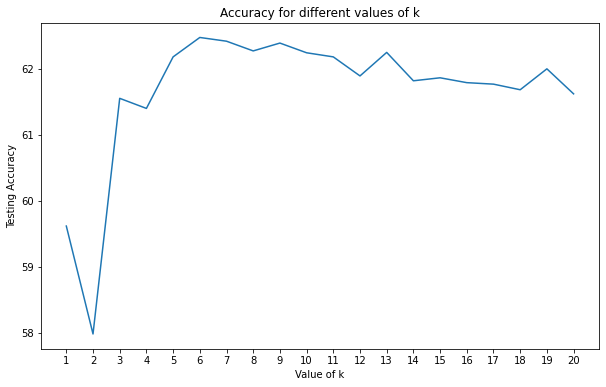

The optimal number of neighbors is 6
Confusion Matrix for knn
[[2729  216  746  749]
 [ 419 3015  746  210]
 [ 976 1020 2215  220]
 [1041  149  146 3091]]


              precision    recall  f1-score   support

        High       0.53      0.61      0.57      4440
         Low       0.69      0.69      0.69      4390
      Medium       0.57      0.50      0.53      4431
   Very High       0.72      0.70      0.71      4427

    accuracy                           0.62     17688
   macro avg       0.63      0.62      0.62     17688
weighted avg       0.63      0.62      0.62     17688

Accuracy: 0.6247173224785165


Gaussian NB
Confusion Matrix for gaussian_nb
[[4379    1   14   46]
 [4245    6   27  112]
 [4381    0    3   47]
 [3951   11  190  275]]


              precision    recall  f1-score   support

        High       0.26      0.99      0.41      4440
         Low       0.33      0.00      0.00      4390
      Medium       0.01      0.00      0.00      4431
   Very High       0

/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anirudhchintha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix for random_forest
[[2631  186  808  815]
 [ 324 2952  907  207]
 [ 791  834 2606  200]
 [ 742   68  132 3485]]


              precision    recall  f1-score   support

        High       0.59      0.59      0.59      4440
         Low       0.73      0.67      0.70      4390
      Medium       0.59      0.59      0.59      4431
   Very High       0.74      0.79      0.76      4427

    accuracy                           0.66     17688
   macro avg       0.66      0.66      0.66     17688
weighted avg       0.66      0.66      0.66     17688

Accuracy: 0.6599954771596562


SVM
Confusion Matrix for svm
[[2294  188  711 1247]
 [ 612 2245 1161  372]
 [1212  494 2130  595]
 [1118   70   72 3167]]


              precision    recall  f1-score   support

        High       0.44      0.52      0.47      4440
         Low       0.75      0.51      0.61      4390
      Medium       0.52      0.48      0.50      4431
   Very High       0.59      0.72      0.65      4427

    accu

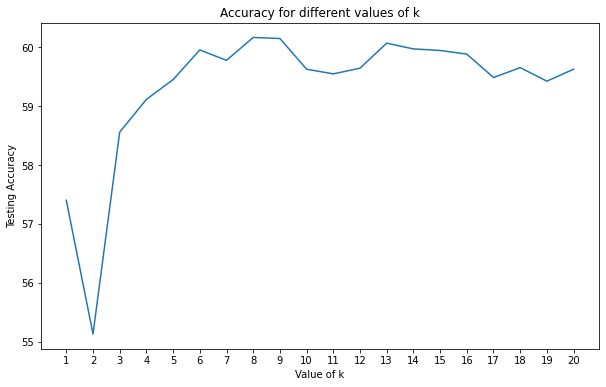

The optimal number of neighbors is 8
Confusion Matrix for knn
[[1925  146  527  469]
 [ 363 1476  639  190]
 [ 672  719 1721  119]
 [ 532   78   53 1686]]


              precision    recall  f1-score   support

        High       0.55      0.63      0.59      3067
         Low       0.61      0.55      0.58      2668
      Medium       0.59      0.53      0.56      3231
   Very High       0.68      0.72      0.70      2349

    accuracy                           0.60     11315
   macro avg       0.61      0.61      0.61     11315
weighted avg       0.60      0.60      0.60     11315

Accuracy: 0.6016791869200177


Gaussian NB
Confusion Matrix for gaussian_nb
[[ 612   16 2399   40]
 [ 322    6 2232  108]
 [ 339    6 2861   25]
 [ 665   71 1277  336]]


              precision    recall  f1-score   support

        High       0.32      0.20      0.24      3067
         Low       0.06      0.00      0.00      2668
      Medium       0.33      0.89      0.48      3231
   Very High       0

In [16]:
# Map each dataframe to a key and execute different models on it
# Save accuracies of every model for each dataframe in a dictionary

df_map = {
    "Median Impute": df_median_impute,
    "Mean Impute": df_mean_inpute,
    "KNN Impute": df_knn_impute,
    "No Impute": df_no_impute,
}

accuracy_map = dict()

for df_key in df_map.keys():
    print("Dataframe: ", df_key)
    print("\n")

    df_item = df_map[df_key]
    accuracy_map[df_key] = dict()

    print("KNN")
    accuracy_map[df_key]["knn"] = train_and_test_model("knn", df_item)
    print("\n")

    print("Gaussian NB")
    accuracy_map[df_key]["gaussian_nb"] = train_and_test_model("gaussian_nb", df_item)
    print("\n")

    print("Decision Tree")
    accuracy_map[df_key]["decision_tree"] = train_and_test_model("decision_tree", df_item)
    print("\n")

    print("CART 5")
    accuracy_map[df_key]["cart_5"] = train_and_test_model("cart_5", df_item)
    print("\n")

    print("Random Forest")
    accuracy_map[df_key]["random_forest"] = train_and_test_model("random_forest", df_item)
    print("\n")

    print("SVM")
    accuracy_map[df_key]["svm"] = train_and_test_model("svm", df_item)
    print("\n")

    print("XG Boost")
    accuracy_map[df_key]["xg_boost"] = use_xg_boost_model(df_item)
    print("\n")

    print("Sequential Dense Model")
    accuracy_map[df_key]["ann"] = use_sequential_dense_modal(df_item)
    print("\n\n")

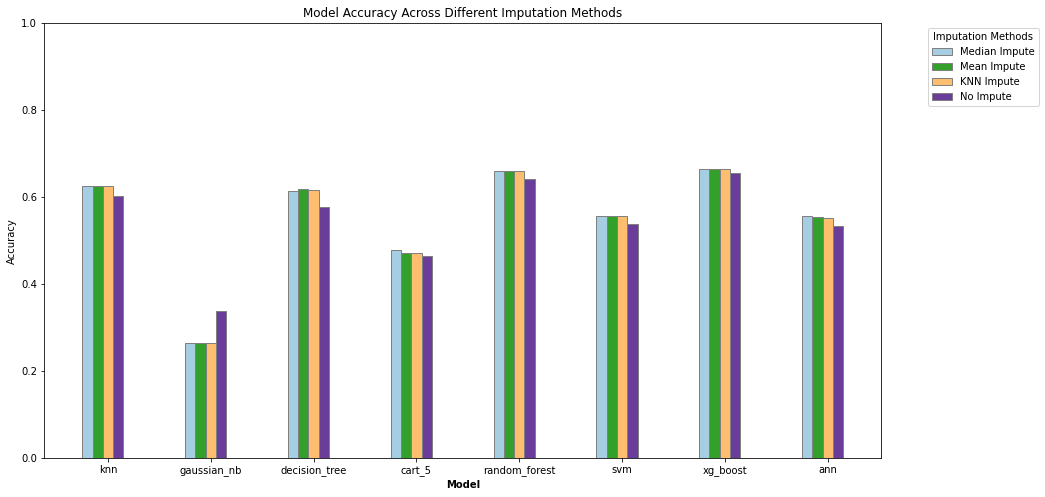

In [17]:
# Using the accuracies map and plotting a bar chart to compare the accuracies of different models acros different imputation methods

models = ["knn", "gaussian_nb", "decision_tree", "cart_5", "random_forest", "svm", "xg_boost", "ann"]

dfs = df_map.keys()
num_groups = len(models)
r = np.arange(num_groups)

bar_width = 0.1

plt.figure(figsize=(15, 8))
for i, df_name in enumerate(dfs):
    accuracies = [accuracy_map[df_name].get(model, 0) for model in models]
    plt.bar(r + i * bar_width, accuracies, color=plt.cm.Paired(i / len(dfs)), width=bar_width, edgecolor='gray', label=df_name)

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width * (len(dfs) / 2) for r in range(num_groups)], models)

plt.legend(title="Imputation Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Across Different Imputation Methods')
plt.ylim(0, 1)

plt.show()

## Finding the best model, best dataset and calculating its accuracy

In [18]:
# Get the model with highest accuracy
max_accuracy = 0
max_accuracy_model = None
max_accuracy_df = None

for df_key in accuracy_map.keys():
    for model in accuracy_map[df_key].keys():
        if accuracy_map[df_key][model] > max_accuracy:
            max_accuracy = accuracy_map[df_key][model]
            max_accuracy_model = model
            max_accuracy_df = df_key

print("Max accuracy:", max_accuracy)
print("Max accuracy model:", max_accuracy_model)
print("Max accuracy df:", max_accuracy_df)

Max accuracy: 0.664179104477612
Max accuracy model: xg_boost
Max accuracy df: Mean Impute


In [19]:
# Calculate the accuracy one last time
if max_accuracy_model == 'xg_boost':
    use_xg_boost_model(df_map[max_accuracy_df])
elif max_accuracy_model == 'ann':
    use_sequential_dense_modal(df_map[max_accuracy_df])
else:
    train_and_test_model(max_accuracy_model, df_map[max_accuracy_df])

Confusion Matrix for XGBClassifier
[[2596  106  773  965]
 [ 331 2879  935  245]
 [ 823  683 2665  260]
 [ 681   24  114 3608]]


              precision    recall  f1-score   support

           0       0.59      0.58      0.59      4440
           1       0.78      0.66      0.71      4390
           2       0.59      0.60      0.60      4431
           3       0.71      0.81      0.76      4427

    accuracy                           0.66     17688
   macro avg       0.67      0.66      0.66     17688
weighted avg       0.67      0.66      0.66     17688

Accuracy: 0.664179104477612


In [21]:
# Get the model with highest accuracy
lowest_accuracy = 100
lowest_accuracy_model = None
lowest_accuracy_df = None

for df_key in accuracy_map.keys():
    for model in accuracy_map[df_key].keys():
        if accuracy_map[df_key][model] < lowest_accuracy:
            lowest_accuracy = accuracy_map[df_key][model]
            lowest_accuracy_model = model
            lowest_accuracy_df = df_key

print("Lowest accuracy:", lowest_accuracy)
print("Lowest accuracy model:", lowest_accuracy_model)
print("Lowest accuracy df:", lowest_accuracy_df)

Lowest accuracy: 0.2636250565355043
Lowest accuracy model: gaussian_nb
Lowest accuracy df: Mean Impute
